In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyedflib
import mne

import random 
import re
from tqdm import tqdm
import pickle

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

In [17]:
DB_PATH = './db/v1.5.1/'

channel_keeps = ['EEG F8-REF', 'EEG T5-REF', 'EEG F7-REF', 'EEG FP1-REF', 'EEG P3-REF', 'EEG P4-REF', 'EEG FZ-REF', 'EEG T4-REF', 'EEG O2-REF', 'EEG F3-REF', 'EEG T6-REF', 'EEG CZ-REF', 'EEG FP2-REF', 'EEG O1-REF', 'EEG C4-REF', 'EEG T3-REF', 'EEG PZ-REF', 'EEG F4-REF', 'EEG C3-REF']


In [2]:
# Load the arrays

with open('datasets/X_train_10.pkl', 'rb') as pickle_file:
    X_train = pickle.load(pickle_file)
    pickle_file.close()
    
with open('datasets/y_train_10.pkl', 'rb') as pickle_file:
    y_train = pickle.load(pickle_file)
    pickle_file.close()
    
with open('datasets/X_test_10.pkl', 'rb') as pickle_file:
    X_test = pickle.load(pickle_file)
    pickle_file.close()
    
with open('datasets/y_test_10.pkl', 'rb') as pickle_file:
    y_test = pickle.load(pickle_file)
    pickle_file.close()
    

In [3]:
# Define the length of each sample

WINDOW_LENGTH = 10 # in seconds 
WINDOW_LENGTH_MS = WINDOW_LENGTH * 250

In [4]:
# Shuffle the data to prevent similar samples getting memorized together

train_indices = tf.range(start=0, limit=tf.shape(X_train)[0], dtype=tf.int32)
test_indices = tf.range(start=0, limit=tf.shape(X_test)[0], dtype=tf.int32)

train_idx = tf.random.shuffle(train_indices)
X_train = tf.gather(X_train, train_idx)
y_train = tf.gather(y_train, train_idx)

test_idx = tf.random.shuffle(test_indices)
X_test = tf.gather(X_test, test_idx)
y_test = tf.gather(y_test, test_idx)

In [5]:
# Define the layers of the model

model = tf.keras.models.Sequential([
    # 100 unit GRU layer
    tf.keras.layers.GRU(100, activation='tanh', input_shape=(WINDOW_LENGTH_MS, 19), return_sequences=True),
    # Add a dropout rate of 0.2
    tf.keras.layers.Dropout(0.5),
    # 100 unit GRU layer
    tf.keras.layers.GRU(100, activation='tanh'),
    # Add a dropout rate of 0.2
    tf.keras.layers.Dropout(0.5),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 'interictal' and 1 for 'preictal'
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 2500, 100)         36300     
_________________________________________________________________
dropout (Dropout)            (None, 2500, 100)         0         
_________________________________________________________________
gru_1 (GRU)                  (None, 100)               60600     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 97,001
Trainable params: 97,001
Non-trainable params: 0
_________________________________________________________________


In [6]:
# Save the model under certain conditions

callback_checkpoint = ModelCheckpoint(filepath='Best_Model.ckpt',
                                      monitor='val_accuracy',
                                      verbose=0,
                                      save_weights_only=True,
                                      save_best_only=True)


callback_early_stopping = EarlyStopping(monitor='val_accuracy', 
                                            min_delta=0, 
                                            patience=3, 
                                            verbose=1,
                                            mode='auto', 
                                            baseline=None, 
                                            restore_best_weights=False)

In [7]:
# Compile the model

model.compile(optimizer=Adam(0.001),
              loss='binary_crossentropy',
              metrics=['accuracy', 'AUC', 'Recall', 'Precision'])

In [8]:
# Train for 20 epochs max

EPOCHS = 20
BATCH_SIZE = 32

history = model.fit(X_train, 
                    y_train,
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_split=0.06,
                    callbacks=[callback_checkpoint, callback_early_stopping],
                    verbose=1)

model.save('GRU10Sec.h5')

Epoch 1/20
125/125 [==============================] - 554s 4s/step - loss: 0.7370 - accuracy: 0.5545 - auc: 0.5517 - recall: 0.4189 - precision: 0.4664 - val_loss: 0.5729 - val_accuracy: 0.7126 - val_auc: 0.7560 - val_recall: 0.4151 - val_precision: 0.8000
Epoch 2/20
125/125 [==============================] - 662s 5s/step - loss: 0.6116 - accuracy: 0.6618 - auc: 0.7003 - recall: 0.4734 - precision: 0.5980 - val_loss: 0.5656 - val_accuracy: 0.7165 - val_auc: 0.7741 - val_recall: 0.6981 - val_precision: 0.6491
Epoch 3/20
125/125 [==============================] - 644s 5s/step - loss: 0.5513 - accuracy: 0.7176 - auc: 0.7776 - recall: 0.6025 - precision: 0.6806 - val_loss: 0.5322 - val_accuracy: 0.6890 - val_auc: 0.7937 - val_recall: 0.6038 - val_precision: 0.6337
Epoch 4/20
125/125 [==============================] - 770s 6s/step - loss: 0.4744 - accuracy: 0.7719 - auc: 0.8414 - recall: 0.6632 - precision: 0.7424 - val_loss: 0.5529 - val_accuracy: 0.7520 - val_auc: 0.8273 - val_recall: 0.5

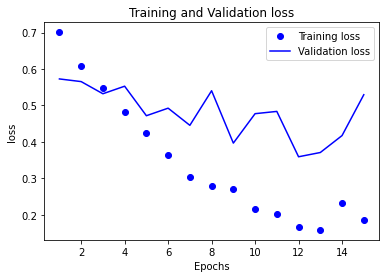

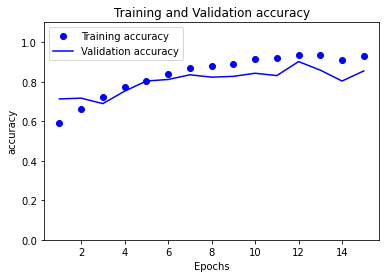

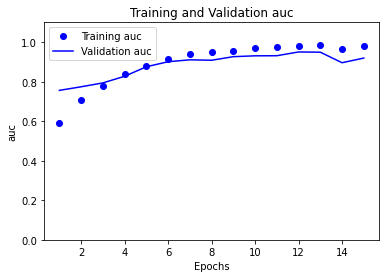

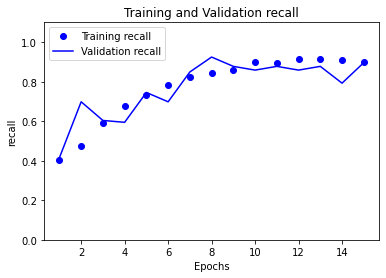

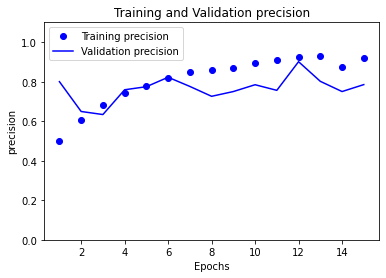

In [9]:
# Plot the progress of training

def plot_progress(history_dict):
  for key in list(history_dict.keys())[:5]:
    plt.clf() # Clears the figure
    training_values = history_dict[key] 
    val_values = history_dict['val_'+key]

    epochs = range(1, len(training_values) + 1)

    plt.plot(epochs, training_values, 'bo', label='Training '+key)

    plt.plot(epochs, val_values, 'b', label='Validation '+key)

    if key != 'loss':
      plt.ylim([0.,1.1])

    plt.title('Training and Validation '+key)
    plt.xlabel('Epochs')
    plt.ylabel(key)
    plt.legend()
    plt.show()
    
plot_progress(history.history)

In [76]:
# Evaluate the trained model with the test set
metrics = model.evaluate(X_test, y_test)

pd.DataFrame(metrics, index = model.metrics_names)

9/9 [==============================] - 9s 959ms/step - loss: 0.4149 - accuracy: 0.8759 - auc: 0.9319 - recall: 0.8609 - precision: 0.8390


,0
loss,0.414946
accuracy,0.875886
auc,0.931867
recall,0.860870
precision,0.838983


In [77]:
# Load data from one file

file_dir = './db/v1.5.1/edf/train/01_tcp_ar/091/00009104/s006_2014_09_23'
EVENTS_FILE = './train/01_tcp_ar/091/00009104/s006_2014_09_23/00009104_s006_t002.tse'

def data_load(data_file, selected_channels=[]):

    try:
        # use the reader to get an EdfReader file
        f = pyedflib.EdfReader(data_file)

        # get the names of the signals
        channel_names = f.getSignalLabels()
        # get the sampling frequencies of each signal
        channel_freq = f.getSampleFrequencies()
        
        # get a list of the EEG channels
        if len(selected_channels) == 0:
            selected_channels = channel_names

        # make an empty file of 0's
        sigbufs = np.zeros((f.getNSamples()[0],len(selected_channels)))
        # for each of the channels in the selected channels
        for i, channel in enumerate(selected_channels):
            try:
              # add the channel data into the array
              sigbufs[:, i] = f.readSignal(channel_names.index(channel))
            
            except:
              ValueError
              sigbufs[:, i] = np.nan


        # turn to a pandas df and save a little space
        df = pd.DataFrame(sigbufs, columns = selected_channels)#.astype('float32')

        # get equally increasing numbers upto the length of the data depending
        # on the length of the data divided by the sampling frequency
        index_increase = np.linspace(0,
                                      len(df)/channel_freq[0],
                                      len(df), endpoint=False)

        seconds = index_increase
        df['Time'] = seconds

        # make the time stamp the index
        df = df.set_index('Time')

        # name the columns as channel
        df.columns.name = 'Channel'

        return df, channel_freq[0]

    except:
        OSError
        return pd.DataFrame(), None

seiz_edf_name = EVENTS_FILE.split('/')[-1][:-3]+'edf'
seiz_edf_file = file_dir +'/'+ seiz_edf_name
seiz_data, seiz_freq = data_load(seiz_edf_file)

print(seiz_edf_file)
display(seiz_data.shape)

./db/v1.5.1/edf/train/01_tcp_ar/091/00009104/s006_2014_09_23/00009104_s006_t002.edf


(284000, 31)

In [78]:
# Create MNE object to visualize the data

def mne_object(data, freq, events_tse = pd.DataFrame()):
  # create an mne info file with meta data about the EEG
  info = mne.create_info(ch_names=list(data.columns), 
                         sfreq=freq, 
                         ch_types=['eeg']*data.shape[-1])
  
  # data needs to be in volts rather than in microvolts
  data = data.apply(lambda x: x*1e-6)
  # transpose the data
  data_T = data.transpose()
  
  # create raw mne object
  raw = mne.io.RawArray(data_T, info)

  if not events_tse.empty:

    raw.set_annotations(mne.Annotations(events_tse['Start'],
                                          events_tse['End'] - events_tse['Start'],
                                          events_tse['Code']))

  return raw

seiz_events_name = EVENTS_FILE.split('/')[-1]
events_tse = pd.read_csv(file_dir+'/'+seiz_events_name, 
                             skiprows=1,
                             sep = ' ',
                             header=None,
                             names =['Start', 'End', 'Code', 'Certainty'])

tuh_mne = mne_object(seiz_data, seiz_freq, events_tse)

print(file_dir+'/'+seiz_events_name)

Creating RawArray with float64 data, n_channels=31, n_times=284000
    Range : 0 ... 283999 =      0.000 ...  1135.996 secs
Ready.
./db/v1.5.1/edf/train/01_tcp_ar/091/00009104/s006_2014_09_23/00009104_s006_t002.tse


Setting up band-pass filter from 0.5 - 70 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.50, 70.00 Hz: -6.02, -6.02 dB



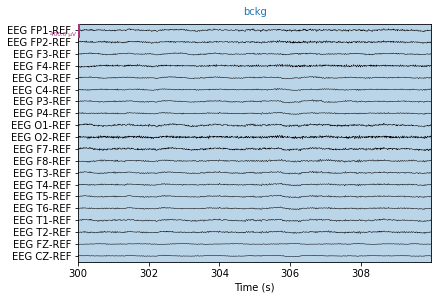

In [79]:
# Plot a segment of the EEG

plot_kwargs = {
    'scalings': dict(eeg=20e-5),   # zooms the plot out
    'highpass': 0.5,              # filters out low frequencies
    'lowpass': 70.,                # filters out high frequencies
    'show_scrollbars': False,
    'show': True
}

fig = tuh_mne.plot(start = 300, duration = 10, **plot_kwargs)
    

In [80]:
# Read files into df and create events series

file_ID = EVENTS_FILE.split('/')[-1][:-4]
# we use the above to get the file directory this file is in
pat_file_dir = 'edf/' + '/'.join(EVENTS_FILE.split('/')[1:-1])
   
file_path = DB_PATH+pat_file_dir+'/'+file_ID+'.edf'
#print(file_path)
pat_ID = EVENTS_FILE.split('/')[-3]

# load data
raw_data, freq = data_load(file_path, channel_keeps)
   
if raw_data.empty:
    print('Skipped: '+file_ID)

interictal = np.array(raw_data) 

In [81]:
WINDOW_LENGTH = 10 # in seconds 
WINDOW_LENGTH_MS = WINDOW_LENGTH * 250

start_index = 600
end_index =start_index + WINDOW_LENGTH_MS

y = [1]
y_real = np.array(y)

query = []
query.append(interictal[start_index:end_index])
query = np.array(query)

print(query.shape)


(1, 2500, 19)


In [82]:
y_pred = model.predict(query)

print(y_pred)

[[0.00100842]]
